<a href="https://colab.research.google.com/github/imenebak/VisDrone_CC/blob/master/DensityVisDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip "/content/drive/My Drive/VisdroneCrowdCounting/Visdrone.zip" -d "/content/"

In [0]:
#set the root to the Shanghai dataset you download
root = '/content/'

In [0]:
import os
#now generate the ShanghaiA's ground truth
train = os.path.join(root,'train/sequences')
test = os.path.join(root,'test/sequences')
path_sets = [train,test]

In [0]:
print(path_sets)

['/content/train/sequences', '/content/test/sequences']


les deux datasets

In [8]:
img_folder_paths = []
for path in path_sets:
  for path, dirs, files in os.walk(path):
    for d in dirs:
      img_folder_paths.append(d)
    break
print(len(img_folder_paths))

112


train dataset

In [9]:
img_folder_paths=[]
for path, dirs, files in os.walk(path_sets[0]):
    for d in dirs:
      img_folder_paths.append(path_sets[0]+"/"+d)
print(len(img_folder_paths))

82


In [0]:
import matplotlib.pyplot as plt

In [0]:
for img_folder_path in img_folder_paths:
    print (img_folder_path)

In [0]:
from google.colab.patches import cv2_imshow

/content/train/sequences/00083
00018.jpg
/content/train/annotations/00083.txt


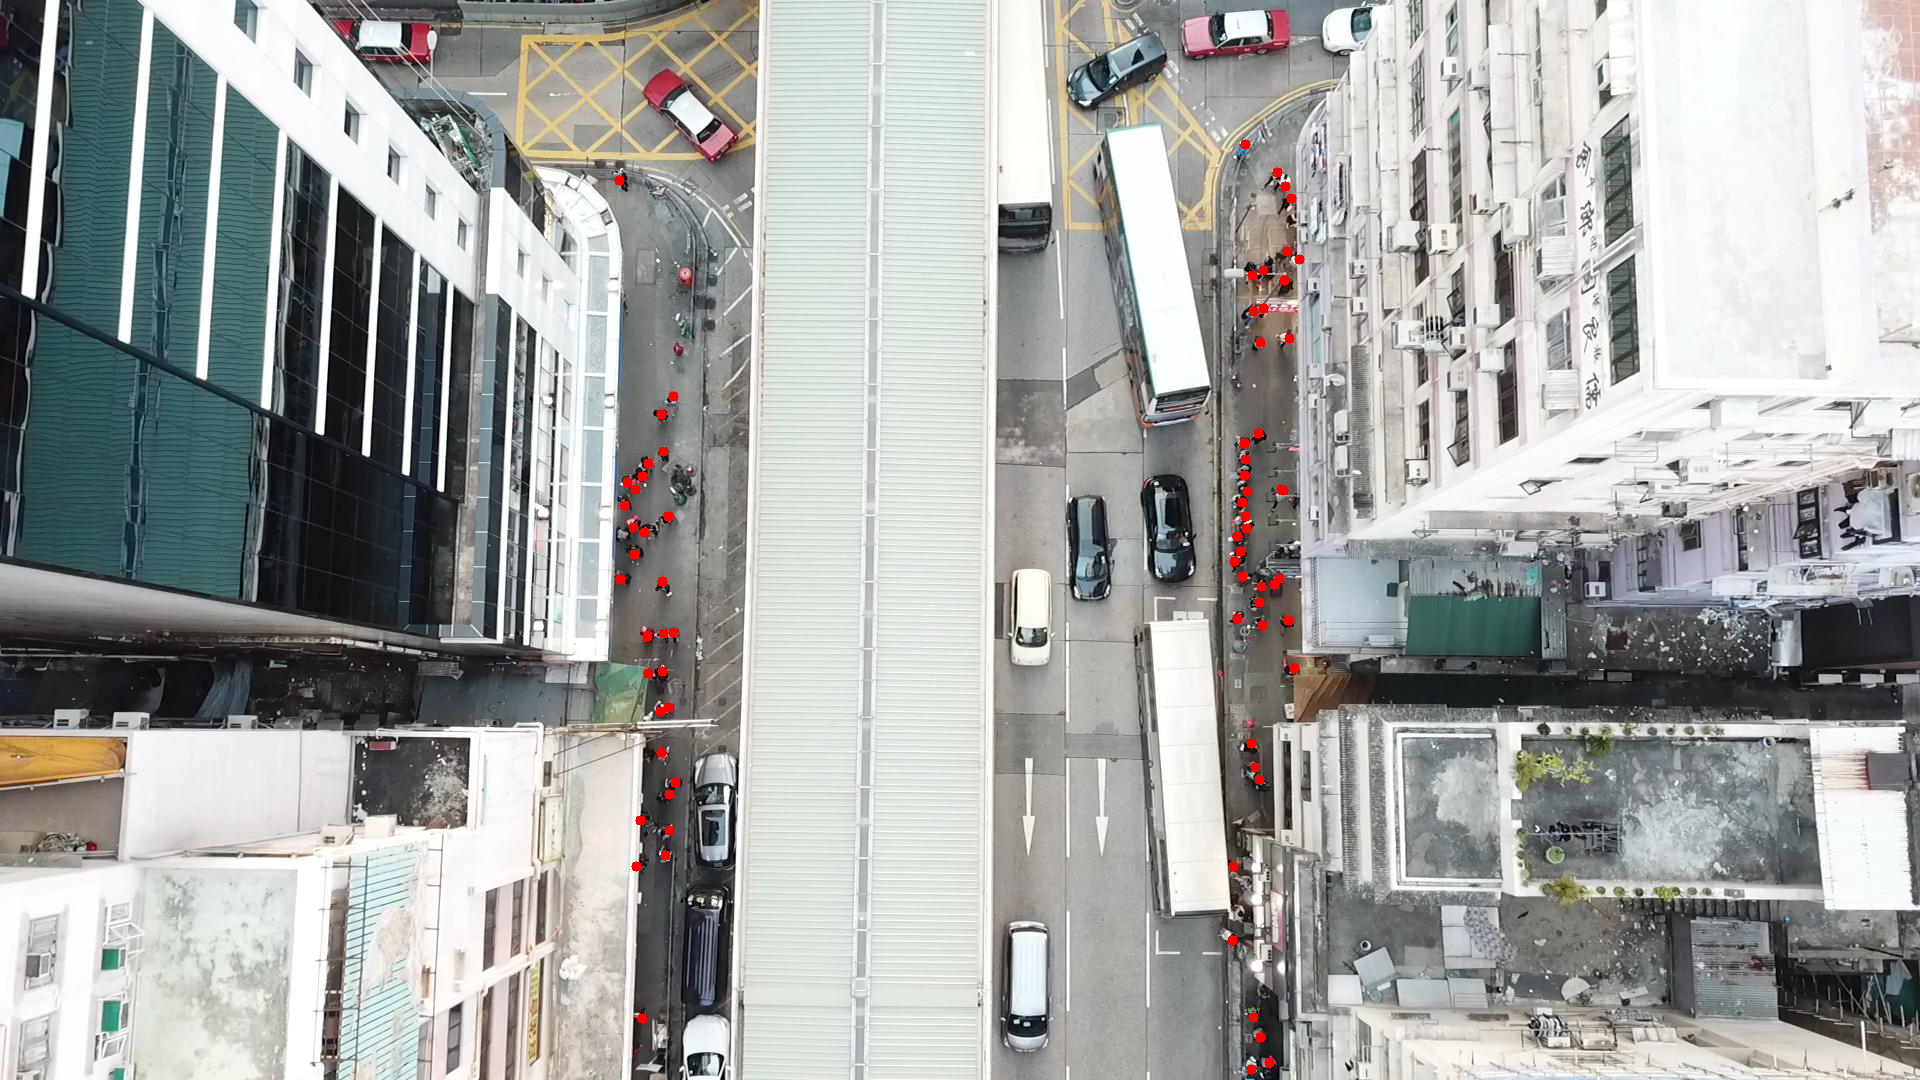

In [12]:
import cv2
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      img= cv2.imread(img_folder_path+"/"+img_path)
      print(img_path)
      annotation = img_path.replace('.jpg','')
      pos = 0
      for nbr in annotation:
        if nbr != '0':
          #print(nbr)
          annotation = annotation[pos:]
          break
        pos+=1
      #print(annotation)
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      #plt.imshow(img)
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        #print(ligne.strip())
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        #print(line)
        if line[0] == int(annotation):
          #print(line[0], int(annotation))
          #plt.scatter([line[1]], line[2])
          img = cv2.circle(img,(line[1],line[2]), 5, (0,0,255), -1)
        
        
      break
  break
cv2_imshow(img)

**Awesome CC density map generation**

In [0]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
#from model import CSRNet
import torch
%matplotlib inline

In [0]:
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    print(pts)
    leafsize = 2048
    # build kdtree
    tree = spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [36]:
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      #img= cv2.imread(img_folder_path+"/"+img_path)
      img = plt.imread(img_folder_path+"/"+img_path)
      print(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      annotation = img_path.replace('.jpg','')
      pos = 0
      #nombre de l'image
      for nbr in annotation:
        if nbr != '0':
          annotation = annotation[pos:]
          break
        pos+=1
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        if line[0] == int(annotation):
          k[line[2], line[1]] = 1
      print(k)
      k = gaussian_filter_density(k)
      with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k
      break
  break

/content/train/sequences/00083
00018.jpg
/content/train/annotations/00083.txt
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1080, 1920)
[[1245  144]
 [1277  172]
 [ 619  180]
 [1285  186]
 [1291  198]
 [1287  251]
 [1299  259]
 [1263  270]
 [1252  275]
 [1284  280]
 [1263  308]
 [1253  311]
 [1289  338]
 [1260  342]
 [ 673  396]
 [ 661  414]
 [1258  433]
 [1244  443]
 [ 663  451]
 [1245  459]
 [ 648  463]
 [1244  475]
 [ 642  476]
 [ 627  482]
 [ 635  489]
 [1281  489]
 [1283  490]
 [1247  491]
 [1242  502]
 [ 624  505]
 [ 668  516]
 [1245  516]
 [ 633  527]
 [1246  528]
 [ 644  532]
 [1237  536]
 [1240  551]
 [ 634  554]
 [1234  561]
 [1242  576]
 [1279  578]
 [ 620  579]
 [ 662  581]
 [1274  584]
 [1261  586]
 [1259  602]
 [1237  618]
 [1288  620]
 [1262  625]
 [ 673  632]
 [ 663  633]
 [ 647  636]
 [1294  668]
 [ 662  671]
 [ 648  673]
 [ 668  707]
 [ 660  711]
 [1251  743]

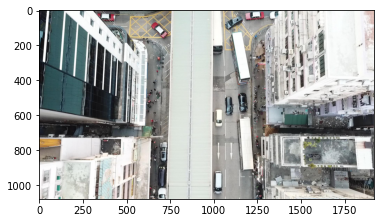

In [42]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_folder_path+"/"+files[0]))

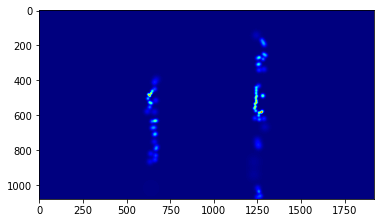

In [44]:
gt_file = h5py.File(files[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [45]:
np.sum(groundtruth)# don't mind this slight variation

73.69227

In [0]:
#now generate the ShanghaiA's ground truth
train = os.path.join(root,'train/sequences')
test = os.path.join(root,'test/sequences')
path_sets = [train,test]

In [47]:
img_folder_paths=[]
for path, dirs, files in os.walk(path_sets[0]):
    for d in dirs:
      img_folder_paths.append(path_sets[0]+"/"+d)
print(len(img_folder_paths))

82


In [49]:
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      #img= cv2.imread(img_folder_path+"/"+img_path)
      img = plt.imread(img_folder_path+"/"+img_path)
      print(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      annotation = img_path.replace('.jpg','')
      pos = 0
      #nombre de l'image
      for nbr in annotation:
        if nbr != '0':
          annotation = annotation[pos:]
          break
        pos+=1
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        if line[0] == int(annotation):
          k[line[2], line[1]] = 1
      print(k)
      k = gaussian_filter(k,15)
      with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truthh'), 'w') as hf:
            hf['density'] = k
      break
  break

/content/train/sequences/00083
00018.jpg
/content/train/annotations/00083.txt
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


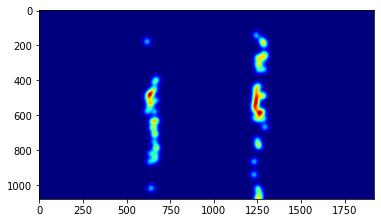

In [53]:
gt_file = h5py.File(files[0].replace('.jpg','.h5').replace('images','ground_truthh),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [54]:
np.sum(groundtruth)

73.99999999999994